In [ ]:
from copy import deepcopy
import datetime
import requests
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
!pip install solrq
from solrq import Q

In [ ]:
IN_TO_CM = 2.54
CM_TO_IN = 1/2.54

In [ ]:
def change_lists_to_strings(results):
    """
    input - list of results from search
    output - list of results with lists changed into strings
    """
    for row in results:
        for data in row:
            if type(row[data]) == list:
                # if there are any numbers in the list change them into strings
                row[data] = [str(a) for a in row[data]]
                # unique and sort the list and then change the list into a string
                row[data] = ','.join(sorted(list(set(row[data]))))

    return results

In [ ]:
# Set up initial values and URLs.
today = datetime.date.today()
year = today.year
search_url = "https://www.ebi.ac.uk/pdbe/search/pdb/select?"
search_terms = Q(status='REL')  # Define the search terms for the PDBe Solr-based query. "I want to search for structures that ..."

In [ ]:
# Define the fields you want to filter and return in the response. "I want to get the following information about these structures:"
filter_terms = [
    'pdb_id', 'number_of_polymer_entities', 'number_of_polymers', 'number_of_bound_entities', 'number_of_bound_molecules',
    'experimental_method', 'release_year', 'resolution', 'ec_number', 'has_bound_molecule', 'bound_compound_id',
    'em_resolution', 'data_quality', 'assembly_mol_wt', 'journal', 'refinement_software',
    'synchrotron_site', 'em_electron_detection', 'cath_homologous_superfamily',
    'assembly_composition', 'processing_site'
]

In [ ]:
# Create a dictionary to format the search parameters.
search_params = {
    'q': search_terms,
    'fl': ','.join(filter_terms),
    'rows': 220,
    'wt': 'json',
    'group': 'true',
    'group.field': 'pdb_id',
    'group.ngroups': 'true'
}

In [ ]:
# Make a POST request to the PDBe search API with the search parameters.
response = requests.post(search_url, data=search_params)

# Check if the request was successful (HTTP status code 200).
if response.status_code == 200:
    response_data = response.json()

    # Extract relevant results from the response.
    preresults = response_data.get('grouped', {}).get('pdb_id', {}).get('groups', [])

    all_results = []

    for group in preresults:
        docs = group.get('doclist', {}).get('docs', [])
        all_results.extend(docs)
else:
    print("[No data retrieved - %s] %s" % (response.status_code, response.text))

In [ ]:
all_results_copy = deepcopy(all_results)
all_results_cleaned = change_lists_to_strings(all_results_copy)

all_results_df = pd.DataFrame(all_results)
all_results_cleaned_df = pd.DataFrame(all_results_cleaned)

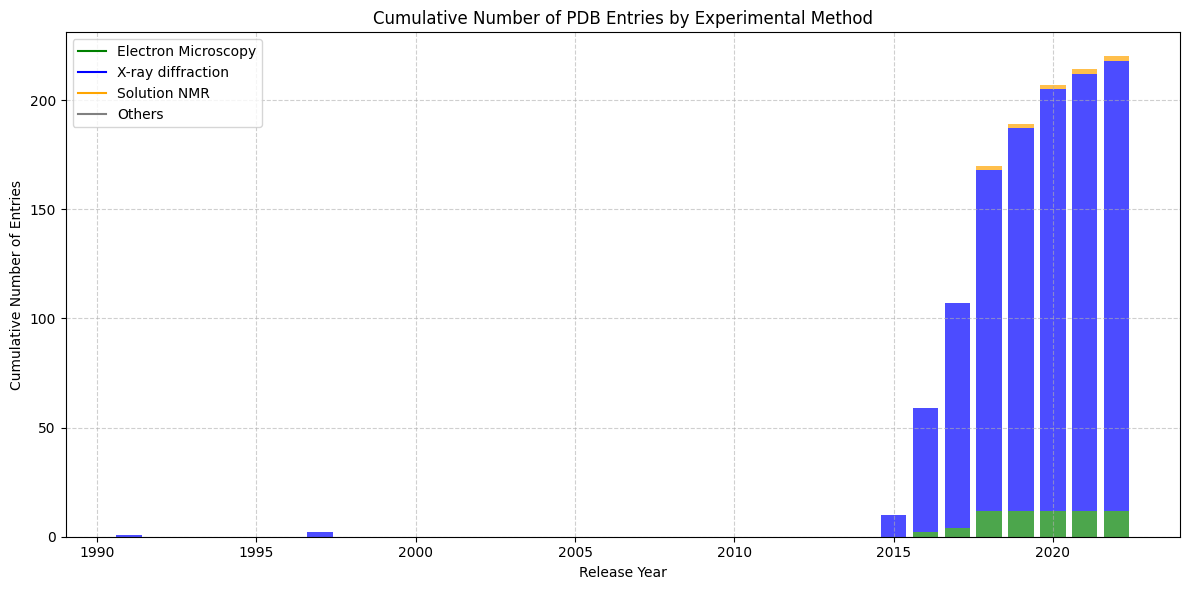

In [ ]:
# Extract the 'release_year' and 'experimental_method' columns
release_years = all_results_cleaned_df['release_year']
experimental_methods = all_results_cleaned_df['experimental_method']

# Count the number of entries per year and sort by year
yearly_counts = release_years.value_counts().sort_index()

# Create a list of unique experimental methods, including 'Others'
selected_methods = ["X-ray diffraction", "Electron Microscopy", "Solution NMR"]
unique_methods = experimental_methods.unique()
unique_methods = [method if method in selected_methods else 'Others' for method in unique_methods]

# Define distinct colors for each method
colors = {
    "X-ray diffraction": 'blue',
    "Electron Microscopy": 'green',
    "Solution NMR": 'orange',
    "Others": 'gray'  # Color for "Others"
}

# Initialize a list to store bar containers for the legend
bar_containers = []

# Create a stacked bar chart for cumulative entries
plt.figure(figsize=(12, 6))

for i, method in enumerate(unique_methods):
    if method != 'Others':
        method_counts = (release_years[experimental_methods == method]
                         .value_counts()
                         .reindex(yearly_counts.index, fill_value=0))
    else:
        # For 'Others,' calculate the counts for all methods not in the selected list
        method_counts = (release_years[~experimental_methods.isin(selected_methods)]
                         .value_counts()
                         .reindex(yearly_counts.index, fill_value=0))

    # Plot bars for each experimental method on the cumulative chart
    if i == 0:
        bar_container = plt.bar(
            yearly_counts.index,
            method_counts.values.cumsum(),
            color=colors[method],  # Use defined color
            alpha=0.7,
            label=method,
            edgecolor='none'  # Remove edges
        )
        bottom_values = method_counts.values.cumsum()
        bar_containers.append(bar_container)
    else:
        if method != 'Others':
            bar_container = plt.bar(
                yearly_counts.index,
                method_counts.values.cumsum(),
                color=colors[method],  # Use defined color
                alpha=0.7,
                bottom=bottom_values,
                label=method,
                edgecolor='none'  # Remove edges
            )
        else:
            bar_container = plt.bar(
                yearly_counts.index,
                method_counts.values.cumsum(),
                color=colors[method],  # Use defined color
                alpha=0.7,
                bottom=bottom_values,
                label=None,  # Hide legend entry for 'Others'
                edgecolor='none'  # Remove edges
            )
        bottom_values += method_counts.values.cumsum()
        bar_containers.append(bar_container)

# Add labels and title for the cumulative chart
plt.xlabel('Release Year')
plt.ylabel('Cumulative Number of Entries')
plt.title('Cumulative Number of PDB Entries by Experimental Method')

# Create a custom legend for 'Others' without multiple entries
legend_labels = [method for method in unique_methods if method != 'Others']
legend_labels.append("Others")
plt.legend(handles=[plt.Line2D([0], [0], color=colors[label], label=label) for label in legend_labels])

# Show the cumulative plot
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('PDBe_release_stats.pdf', dpi = 300, bbox_inches = 'tight', transparent = True)
plt.show()